<a href="https://colab.research.google.com/github/EnsarIshakoglu/NLP/blob/master/NLP_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Source: https://keras.io/examples/nlp/multi_label_classification/#introduction
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval

# Tensorflow
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa

# Keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Input
from keras.layers import Dense, Conv1D, SeparableConv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Embedding

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Data processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Stackapi to fetch stackoverflow api
!pip install stackapi
from stackapi import StackAPI

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Mount colab drive to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fetch data

In [ ]:
# Get the data from stackoverflow sorted by votes
def fetch_data():
  data = []
  page_count = 16
  SITE = StackAPI('stackoverflow')

  for i in range(page_count):
    data.append(SITE.fetch('questions', sort="votes", min=20, filter='withbody', page=i + 1))
  
  return data

## Remove useless data

In [ ]:
def clean_data(data):
  raw_df = pd.DataFrame(pd.DataFrame.from_dict(data[0]['items']))
  for i in range(len(data) - 1):
    raw_df = raw_df.append(pd.DataFrame.from_dict(data[i + 1]['items']))
  
  df = raw_df[['tags', 'body']]

  # Strip html tags with regex:
  df['body'] = df['body'].str.replace(r'<[^<>]*>', '', regex=True)

  # Get first tag for multi-class classification
  row_count = df.shape[0]

  for i in range(row_count):
    df['tags'].iloc[i] = df['tags'].iloc[i][0]
  
  return df

### Create folder and file from df, unmout drive after

In [ ]:
from os.path import exists

!mkdir stackoverflow

if not exists('/content/stackoverflow/questions.csv'):
  data = fetch_data()
  df = clean_data(data)
  df.to_csv('/content/stackoverflow/questions.csv')
  print("Fetched data from stackoverflow, removed the useless data and saved it in stackoverflow/questions.csv")

drive.flush_and_unmount()

mkdir: cannot create directory ‘stackoverflow’: File exists


### Load file from drive

In [ ]:
df = pd.read_csv('/content/stackoverflow/questions.csv')

df.head()

,Unnamed: 0,tags,body
0,0,java,Here is a piece of C++ code that shows some ve...
1,1,git,I accidentally committed the wrong files to Gi...
2,2,git,I want to delete a branch both locally and rem...
3,3,git,What are the differences between git pull and ...
4,4,python,What is the use of the yield keyword in Python...


In [ ]:
print(f"There are {len(df['body'].unique())} rows in the dataset.")

There are 2000 rows in the dataset.


In [ ]:
df = df[~df['body'].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 2000 rows in the deduplicated dataset.


In [ ]:
# There are a lot of terms with occurrence below 6.
threshold = 20

print(sum(df['tags'].value_counts() < threshold))

# How many unique terms?
print(df['tags'].nunique())

129
145


In [ ]:
# Filtering the rare terms because there is not enough data to train properly with.
df_filtered = df.groupby("tags").filter(lambda x: len(x) > threshold)
df_filtered.shape

(1594, 3)

In [ ]:
# Remove punctuation
df_filtered['body'] = df_filtered['body'].replace('[^\w\s]','', regex=True)
df_filtered['body'] = df_filtered['body'].replace(r'\s+|\\n', ' ', regex=True) 
    
df_filtered.head()

,Unnamed: 0,tags,body
0,0,java,Here is a piece of C code that shows some very...
1,1,git,I accidentally committed the wrong files to Gi...
2,2,git,I want to delete a branch both locally and rem...
3,3,git,What are the differences between git pull and ...
4,4,python,What is the use of the yield keyword in Python...


In [ ]:
# Source: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_filtered['body'] = df_filtered['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_filtered.head()

,Unnamed: 0,tags,body
0,0,java,Here piece C code shows peculiar behavior For ...
1,1,git,I accidentally committed wrong files Git didnt...
2,2,git,I want delete branch locally remotely Failed A...
3,3,git,What differences git pull git fetch
4,4,python,What use yield keyword Python What For example...


In [ ]:
# Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize words
lemmatizer = WordNetLemmatizer()
df_filtered['body'] = df_filtered['body'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x.split()]))
df_filtered.head()

,Unnamed: 0,tags,body
0,0,java,Here piece C code show peculiar behavior For s...
1,1,git,I accidentally commit wrong file Git didnt pus...
2,2,git,I want delete branch locally remotely Failed A...
3,3,git,What difference git pull git fetch
4,4,python,What use yield keyword Python What For example...


In [ ]:
# Check class imbalance:
print(df_filtered.groupby(df_filtered['tags']).size())

tags
android        59
bash           44
c#            108
c++            61
css            36
git           253
html           65
ios            21
java          147
javascript    349
linux          33
mysql          23
node.js        22
php            44
python        289
sql            40
dtype: int64


## Prepare data

In [ ]:
df_filtered['label'] = pd.factorize(df_filtered['tags'])[0]
df_filtered.head()

,Unnamed: 0,tags,body,label
0,0,java,Here piece C code show peculiar behavior For s...,0
1,1,git,I accidentally commit wrong file Git didnt pus...,1
2,2,git,I want delete branch locally remotely Failed A...,1
3,3,git,What difference git pull git fetch,1
4,4,python,What use yield keyword Python What For example...,2


In [ ]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(df_filtered['body'])
vectorizer.transform(df_filtered['body']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Use stratified splits because of class imbalance
X = df_filtered['body']
y = df_filtered['label']

# Initial train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=132)

# Splitting the test set further into validation and new test sets.
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=23)

print(f"Number of rows in training set: {len(X_train)}")
print(f"Number of rows in validation set: {len(X_val)}")
print(f"Number of rows in test set: {len(X_test)}")

Number of rows in training set: 1275
Number of rows in validation set: 160
Number of rows in test set: 159


In [ ]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

In [ ]:
# Dataset preview
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (1275, 11763)
X_test shape: (159, 11763)
X_val shape: (160, 11763)


In [ ]:
y_train.shape

(1275,)

## Create model

In [ ]:
# Amount of columns in data:
input_dim = X_train.shape[1]

# Amount of unique labels:
output_dim = y_train.nunique()

print(f'Input dim: {input_dim}')
print(f'Output dim: {output_dim}')

Input dim: 11763
Output dim: 16


In [ ]:
# Reshape labels
label_encoder = LabelEncoder()
y_train = np.array(label_encoder.fit_transform(y_train))
y_val = np.array(label_encoder.fit_transform(y_val))
y_test = np.array(label_encoder.fit_transform(y_test))

y_train = tf.one_hot(y_train, depth=output_dim)
y_val = tf.one_hot(y_val, depth=output_dim)
y_test = tf.one_hot(y_test, depth=output_dim)

In [ ]:
def conv_model():
    model = Sequential()
    model.add(Dense(128, input_dim = input_dim, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))

    model.add(Dense(output_dim, activation='softmax'))

    return model

In [ ]:
# First define baseline model. Then use it in Keras Classifier for the training
def baseline_model():
    # Create model here
    model = Sequential()
    model.add(Dense(200, input_dim = input_dim, activation = 'relu')) # Rectified Linear Unit Activation Function
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))

    model.add(Dense(output_dim, activation = 'softmax')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

## Evaluate model

In [ ]:
model = conv_model()

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               1505792   
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 16)               

In [ ]:
# For Keras, convert dataframe to array values (Inbuilt requirement of Keras)
X = X_train
y = y_train

Epoch 1/18


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_10/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_10/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_10/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


10/10 [==============================] - 1s 49ms/step - loss: 0.6729 - categorical_accuracy: 0.1788 - val_loss: 0.6330 - val_categorical_accuracy: 0.2000
Epoch 2/18
10/10 [==============================] - 0s 31ms/step - loss: 0.6121 - categorical_accuracy: 0.1788 - val_loss: 0.5614 - val_categorical_accuracy: 0.2000
Epoch 3/18
10/10 [==============================] - 0s 28ms/step - loss: 0.5321 - categorical_accuracy: 0.1788 - val_loss: 0.4851 - val_categorical_accuracy: 0.2000
Epoch 4/18
10/10 [==============================] - 0s 30ms/step - loss: 0.4505 - categorical_accuracy: 0.1788 - val_loss: 0.3987 - val_categorical_accuracy: 0.2000
Epoch 5/18
10/10 [==============================] - 0s 30ms/step - loss: 0.3356 - categorical_accuracy: 0.1788 - val_loss: 0.2679 - val_categorical_accuracy: 0.2000
Epoch 6/18
10/10 [==============================] - 0s 28ms/step - loss: 0.2281 - categorical_accuracy: 0.2604 - val_loss: 0.2091 - val_categorical_accuracy: 0.4750
Epoch 7/18
10/10 [===

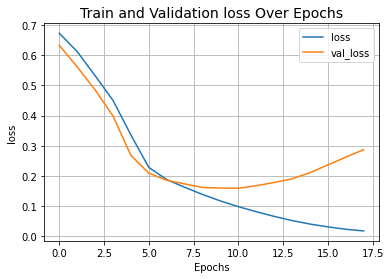

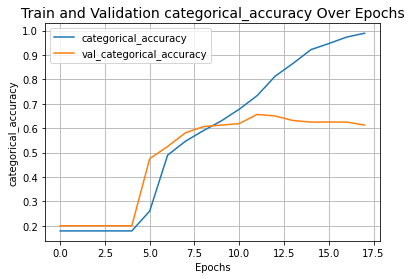

In [ ]:
history = model.fit(X, y, validation_data=[X_val, y_val], batch_size = 128, epochs = 18, verbose = 1)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = model.evaluate(X_test, y_test)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

5/5 [==============================] - 0s 5ms/step - loss: 0.2943 - categorical_accuracy: 0.5597
Categorical accuracy on the test set: 55.97%.
